In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Biblioteka do połączenia z google.trends
from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError
# Funkcja czyszcząca output do zrobienia progress countera
from IPython.display import clear_output
%matplotlib inline
sns.set_style()

In [58]:
movies_raw = pd.read_csv('tmdb_5000_movies.csv')

In [3]:
# Movies based on vote rate and vote count
rated_movies = movies_raw[(movies_raw['vote_average']>7) & (movies_raw['vote_count']>737)]

In [170]:
# Movies over 1 000 000 000$ revenue
billion_movies = movies_raw[movies_raw['revenue']>=1000000000]

In [68]:
top5 = billion_movies.sort_values(by='revenue', ascending=False).head()

In [59]:
def timeframe(date):
    # Setting start_date as release_date - 40, same with stop_date
    start_date, stop_date = pd.to_datetime(date) - pd.Timedelta(days=40), pd.to_datetime(date) + pd.Timedelta(days=40)
    # Converting timestamps to string for build_payload timeframe format = 'YYYY-MM-dd YYYY-MM-dd'
    timeframe = ' '.join([start_date.strftime('%Y-%m-%d'), stop_date.strftime('%Y-%m-%d')])
    return timeframe

In [60]:
def trends(movies):
    err_titles = {}
    trends_df = pd.DataFrame()
    pytrends = TrendReq(hl='en-US', tz=360)
    for i in range(movies.shape[0]):
        # Wyświetlam ile jeszcze filmów zostało do końca, na końcu pętli czyszczę ekran
        print(movies.shape[0]-i)
        # try/except: Jeśli film wydano w roku przed dostępnością danych to przechodzi do except
        try:
            # Przypisuję tytuł filmu do kw_lisy
            kw_list = [movies['title'].iloc[i]]
            # Tworzę zakres dat dla google.trends
            date = timeframe(movies['release_date'].iloc[i])
            # Wysyłam request do google.trends
            pytrends.build_payload(kw_list, cat=0, timeframe=date,geo='',gprop='')
            pytrends_df = pytrends.interest_over_time()
            # Tworzę pustą multilevel DF
            temp_df = pd.DataFrame(columns=pd.MultiIndex.from_product([kw_list, ['Date','Freq']], names=['Title','']))
            # Uzupełniam Date i Freq z DF otrzymanej od google.trends
            temp_df.loc[:,(kw_list[0],'Date')] = pytrends_df.reset_index().iloc[:,0]
            temp_df.loc[:,(kw_list[0],'Freq')] = pytrends_df.reset_index().iloc[:,1]
            # dodaję DF z google.trends trends_df
            trends_df = pd.concat([trends_df,temp_df], axis=1)
        # Jeśli wystąpi error to dodaję tytuł i rok wydania filmu do słownika err_titles, a potem zwiększam i
        except ResponseError:
            err_titles[movies['title'].iloc[i]] = movies['release_date'].iloc[i]
            i += 1
        clear_output()
    # Funkcja zwraca 2 wartości
    return trends_df, err_titles

In [ ]:
# Splitting genres (list of dicts as string originaly) into list of strings ex.
# '[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}' => ['Action', 'Adventure']
import ast
def split_genres_apply(movie):
    categories = []
    # This splits string into dictionary
    for d in ast.literal_eval(movie):
        categories.append(d['name'])
    return categories

In [ ]:
movies_categories = rated_movies.copy()

In [ ]:
# Apply split_genres to each genres row and put new list into new column ['categories']
movies_categories['categories'] = movies_categories['genres'].apply(lambda x: split_genres_apply(x))

In [ ]:
# Look for movies that have 'category' in categories list
movies_categories[movies_categories['categories'].apply(lambda x: True if 'History' in x else False)][['title', 'release_date']]

In [98]:
# EDA

In [216]:
top5rated = rated_movies.sort_values(by=['vote_count', 'vote_average'], ascending=False).head()

In [14]:
trends_df, err_titles = trends(top5rated)

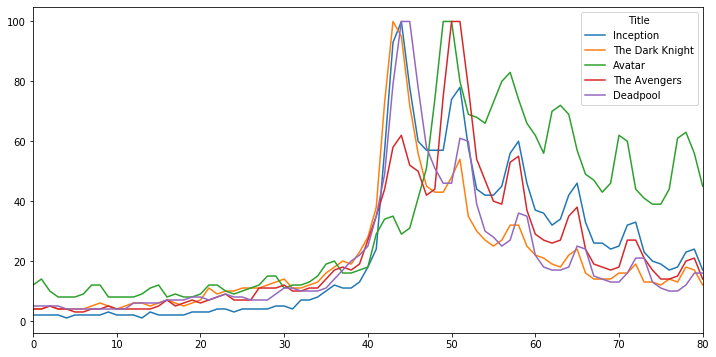

In [20]:
trends_df.xs('Freq', axis=1, level=1).plot(figsize=(12,6))